# Packages

In [1]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.1 MB/s eta 0:00:00a 0:00:01


# DATA

In [2]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader

def create_synthetic_dataset(N, N_input,N_output,sigma):
    # N: number of samples in each split (train, test)
    # N_input: import of time steps in input series
    # N_output: import of time steps in output series
    # sigma: standard deviation of additional noise
    X = []
    breakpoints = []
    for k in range(2*N):
        serie = np.array([ sigma*random.random() for i in range(N_input+N_output)])
        i1 = random.randint(1,10)
        i2 = random.randint(10,18)
        j1 = random.random()
        j2 = random.random()
        interval = abs(i2-i1) + random.randint(-3,3)
        serie[i1:i1+1] += j1
        serie[i2:i2+1] += j2
        serie[i2+interval:] += (j2-j1)
        X.append(serie)
        breakpoints.append(i2+interval)
    X = np.stack(X)
    breakpoints = np.array(breakpoints)
    return X[0:N,0:N_input], X[0:N, N_input:N_input+N_output], X[N:2*N,0:N_input], X[N:2*N, N_input:N_input+N_output],breakpoints[0:N], breakpoints[N:2*N]


class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, X_input, X_target, breakpoints):
        super(SyntheticDataset, self).__init__()
        self.X_input = X_input
        self.X_target = X_target
        self.breakpoints = breakpoints

    def __len__(self):
        return (self.X_input).shape[0]

    def __getitem__(self, idx):
        return (self.X_input[idx,:,np.newaxis], self.X_target[idx,:,np.newaxis]  , self.breakpoints[idx])


# Loss

## Path soft dtw:

In [3]:
import numpy as np
import torch
from torch.autograd import Function
from numba import jit


@jit(nopython = True)
def my_max(x, gamma):
    # use the log-sum-exp trick
    max_x = np.max(x)
    exp_x = np.exp((x - max_x) / gamma)
    Z = np.sum(exp_x)
    return gamma * np.log(Z) + max_x, exp_x / Z

@jit(nopython = True)
def my_min(x,gamma) :
    min_x, argmax_x = my_max(-x, gamma)
    return - min_x, argmax_x

@jit(nopython = True)
def my_max_hessian_product(p, z, gamma):
    return  ( p * z - p * np.sum(p * z) ) /gamma

@jit(nopython = True)
def my_min_hessian_product(p, z, gamma):
    return - my_max_hessian_product(p, z, gamma)


@jit(nopython = True)
def dtw_grad(theta, gamma):
    m = theta.shape[0]
    n = theta.shape[1]
    V = np.zeros((m + 1, n + 1))
    V[:, 0] = 1e10
    V[0, :] = 1e10
    V[0, 0] = 0

    Q = np.zeros((m + 2, n + 2, 3))

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # theta is indexed starting from 0.
            v, Q[i, j] = my_min(np.array([V[i, j - 1],
                                                V[i - 1, j - 1],
                                                V[i - 1, j]]) , gamma)
            V[i, j] = theta[i - 1, j - 1] + v

    E = np.zeros((m + 2, n + 2))
    E[m + 1, :] = 0
    E[:, n + 1] = 0
    E[m + 1, n + 1] = 1
    Q[m + 1, n + 1] = 1

    for i in range(m,0,-1):
        for j in range(n,0,-1):
            E[i, j] = Q[i, j + 1, 0] * E[i, j + 1] + \
                      Q[i + 1, j + 1, 1] * E[i + 1, j + 1] + \
                      Q[i + 1, j, 2] * E[i + 1, j]

    return V[m, n], E[1:m + 1, 1:n + 1], Q, E


@jit(nopython = True)
def dtw_hessian_prod(theta, Z, Q, E, gamma):
    m = Z.shape[0]
    n = Z.shape[1]

    V_dot = np.zeros((m + 1, n + 1))
    V_dot[0, 0] = 0

    Q_dot = np.zeros((m + 2, n + 2, 3))
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            # theta is indexed starting from 0.
            V_dot[i, j] = Z[i - 1, j - 1] + \
                          Q[i, j, 0] * V_dot[i, j - 1] + \
                          Q[i, j, 1] * V_dot[i - 1, j - 1] + \
                          Q[i, j, 2] * V_dot[i - 1, j]

            v = np.array([V_dot[i, j - 1], V_dot[i - 1, j - 1], V_dot[i - 1, j]])
            Q_dot[i, j] = my_min_hessian_product(Q[i, j], v, gamma)
    E_dot = np.zeros((m + 2, n + 2))

    for j in range(n,0,-1):
        for i in range(m,0,-1):
            E_dot[i, j] = Q_dot[i, j + 1, 0] * E[i, j + 1] + \
                          Q[i, j + 1, 0] * E_dot[i, j + 1] + \
                          Q_dot[i + 1, j + 1, 1] * E[i + 1, j + 1] + \
                          Q[i + 1, j + 1, 1] * E_dot[i + 1, j + 1] + \
                          Q_dot[i + 1, j, 2] * E[i + 1, j] + \
                          Q[i + 1, j, 2] * E_dot[i + 1, j]

    return V_dot[m, n], E_dot[1:m + 1, 1:n + 1]


class PathDTWBatch(Function):
    @staticmethod
    def forward(ctx, D, gamma): # D.shape: [batch_size, N , N]
        batch_size,N,N = D.shape
        device = D.device
        D_cpu = D.detach().cpu().numpy()
        gamma_gpu = torch.FloatTensor([gamma]).to(device)

        grad_gpu = torch.zeros((batch_size, N ,N)).to(device)
        Q_gpu = torch.zeros((batch_size, N+2 ,N+2,3)).to(device)
        E_gpu = torch.zeros((batch_size, N+2 ,N+2)).to(device)

        for k in range(0,batch_size): # loop over all D in the batch
            _, grad_cpu_k, Q_cpu_k, E_cpu_k = dtw_grad(D_cpu[k,:,:], gamma)
            grad_gpu[k,:,:] = torch.FloatTensor(grad_cpu_k).to(device)
            Q_gpu[k,:,:,:] = torch.FloatTensor(Q_cpu_k).to(device)
            E_gpu[k,:,:] = torch.FloatTensor(E_cpu_k).to(device)
        ctx.save_for_backward(grad_gpu,D, Q_gpu ,E_gpu, gamma_gpu)
        return torch.mean(grad_gpu, dim=0)

    @staticmethod
    def backward(ctx, grad_output):
        device = grad_output.device
        grad_gpu, D_gpu, Q_gpu, E_gpu, gamma = ctx.saved_tensors
        D_cpu = D_gpu.detach().cpu().numpy()
        Q_cpu = Q_gpu.detach().cpu().numpy()
        E_cpu = E_gpu.detach().cpu().numpy()
        gamma = gamma.detach().cpu().numpy()[0]
        Z = grad_output.detach().cpu().numpy()

        batch_size,N,N = D_cpu.shape
        Hessian = torch.zeros((batch_size, N ,N)).to(device)
        for k in range(0,batch_size):
            _, hess_k = dtw_hessian_prod(D_cpu[k,:,:], Z, Q_cpu[k,:,:,:], E_cpu[k,:,:], gamma)
            Hessian[k:k+1,:,:] = torch.FloatTensor(hess_k).to(device)

        return  Hessian, None

## Soft DTW

In [4]:
import numpy as np
import torch
from numba import jit
from torch.autograd import Function

def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    return torch.clamp(dist, 0.0, float('inf'))

@jit(nopython = True)
def compute_softdtw(D, gamma):
  N = D.shape[0]
  M = D.shape[1]
  R = np.zeros((N + 2, M + 2)) + 1e8
  R[0, 0] = 0
  for j in range(1, M + 1):
    for i in range(1, N + 1):
      r0 = -R[i - 1, j - 1] / gamma
      r1 = -R[i - 1, j] / gamma
      r2 = -R[i, j - 1] / gamma
      rmax = max(max(r0, r1), r2)
      rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
      softmin = - gamma * (np.log(rsum) + rmax)
      R[i, j] = D[i - 1, j - 1] + softmin
  return R

@jit(nopython = True)
def compute_softdtw_backward(D_, R, gamma):
  N = D_.shape[0]
  M = D_.shape[1]
  D = np.zeros((N + 2, M + 2))
  E = np.zeros((N + 2, M + 2))
  D[1:N + 1, 1:M + 1] = D_
  E[-1, -1] = 1
  R[:, -1] = -1e8
  R[-1, :] = -1e8
  R[-1, -1] = R[-2, -2]
  for j in range(M, 0, -1):
    for i in range(N, 0, -1):
      a0 = (R[i + 1, j] - R[i, j] - D[i + 1, j]) / gamma
      b0 = (R[i, j + 1] - R[i, j] - D[i, j + 1]) / gamma
      c0 = (R[i + 1, j + 1] - R[i, j] - D[i + 1, j + 1]) / gamma
      a = np.exp(a0)
      b = np.exp(b0)
      c = np.exp(c0)
      E[i, j] = E[i + 1, j] * a + E[i, j + 1] * b + E[i + 1, j + 1] * c
  return E[1:N + 1, 1:M + 1]


class SoftDTWBatch(Function):
    @staticmethod
    def forward(ctx, D, gamma = 1.0): # D.shape: [batch_size, N , N]
        dev = D.device
        batch_size,N,N = D.shape
        gamma = torch.FloatTensor([gamma]).to(dev)
        D_ = D.detach().cpu().numpy()
        g_ = gamma.item()

        total_loss = 0
        R = torch.zeros((batch_size, N+2 ,N+2)).to(dev)
        for k in range(0, batch_size): # loop over all D in the batch
            Rk = torch.FloatTensor(compute_softdtw(D_[k,:,:], g_)).to(dev)
            R[k:k+1,:,:] = Rk
            total_loss = total_loss + Rk[-2,-2]
        ctx.save_for_backward(D, R, gamma)
        return total_loss / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        D, R, gamma = ctx.saved_tensors
        batch_size,N,N = D.shape
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        g_ = gamma.item()

        E = torch.zeros((batch_size, N ,N)).to(dev)
        for k in range(batch_size):
            Ek = torch.FloatTensor(compute_softdtw_backward(D_[k,:,:], R_[k,:,:], g_)).to(dev)
            E[k:k+1,:,:] = Ek

        return grad_output * E, None




## Loss

In [5]:
def dilate_loss(outputs, targets, alpha, gamma, device):
    # outputs, targets: shape (batch_size, N_output, 1)
    batch_size, N_output = outputs.shape[0:2]
    loss_shape = 0
    softdtw_batch = SoftDTWBatch.apply  # Use the directly imported function
    D = torch.zeros((batch_size, N_output, N_output)).to(device)
    for k in range(batch_size):
        Dk = pairwise_distances(
            targets[k, :, :].view(-1, 1), outputs[k, :, :].view(-1, 1)
        )  # Use directly imported pairwise_distances
        D[k : k + 1, :, :] = Dk
    loss_shape = softdtw_batch(D, gamma)

    path_dtw = PathDTWBatch.apply  # Use the directly imported function
    path = path_dtw(D, gamma)
    Omega = pairwise_distances(torch.arange(1, N_output + 1).view(N_output, 1)).to(device)
    loss_temporal = torch.sum(path * Omega) / (N_output * N_output)
    loss = alpha * loss_shape + (1 - alpha) * loss_temporal
    return loss, loss_shape, loss_temporal


# Models

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderRNN(torch.nn.Module):
    def __init__(self,input_size, hidden_size, num_grulstm_layers, batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_grulstm_layers = num_grulstm_layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_grulstm_layers,batch_first=True)

    def forward(self, input, hidden): # input [batch_size, length T, dimensionality d]
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def init_hidden(self,device):
        #[num_layers*num_directions,batch,hidden_size]
        return torch.zeros(self.num_grulstm_layers, self.batch_size, self.hidden_size, device=device)

class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_grulstm_layers,fc_units, output_size):
        super(DecoderRNN, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_grulstm_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, fc_units)
        self.out = nn.Linear(fc_units, output_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        output = F.relu( self.fc(output) )
        output = self.out(output)
        return output, hidden

class Net_GRU(nn.Module):
    def __init__(self, encoder, decoder, target_length, device):
        super(Net_GRU, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_length = target_length
        self.device = device

    def forward(self, x):
        input_length  = x.shape[1]
        encoder_hidden = self.encoder.init_hidden(self.device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(x[:,ei:ei+1,:]  , encoder_hidden)

        decoder_input = x[:,-1,:].unsqueeze(1) # first decoder input= last element of input sequence
        decoder_hidden = encoder_hidden

        outputs = torch.zeros([x.shape[0], self.target_length, x.shape[2]]  ).to(self.device)
        for di in range(self.target_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_input = decoder_output
            outputs[:,di:di+1,:] = decoder_output
        return outputs

# Reproduction des expériences tableau synthetic data

In [7]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#cuda:0
random.seed(0)

# parameters data
batch_size = 100
N = 500
N_input = 20
N_output = 20
sigma = 0.01


# Load synthetic dataset
X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)


def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    training_history = []

    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)

            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse

            if (loss_type=='dilate'):
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                tuple_errors = eval_model(net,testloader, gamma,verbose=1)
                training_history.append(tuple_errors)
                
    return training_history


def eval_model(net,loader, gamma,verbose=1):
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)

        # MSE
        loss_mse = criterion(target,outputs)
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            path, sim = dtw_path(target_k_cpu, output_k_cpu)
            loss_dtw += sim

            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)

        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )
    mse_mean = np.array(losses_mse).mean()
    dtw_mean = np.array(losses_dtw).mean()
    tdi_mean = np.array(losses_tdi).mean() 
    
    print( ' Eval mse= ', mse_mean ,' dtw= ',dtw_mean ,' tdi= ', tdi_mean)
    
    return (mse_mean,dtw_mean,tdi_mean)



## Train model(evaluation is included)
Questions:
lambda wtf 

In [8]:
#training parameters:
gamma = 0.001
alpha = 0.5

In [11]:
#GRU on DILATE
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
history_dilate = train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1, Lambda = 1, alpha = alpha)


epoch  0  loss  1.11678946018219  loss shape  2.196817636489868  loss temporal  0.036761265248060226
 Eval mse=  0.13435404747724533  dtw=  1.3454335143112715  tdi=  0.06106
epoch  50  loss  0.7975399494171143  loss shape  1.3020473718643188  loss temporal  0.2930324673652649
 Eval mse=  0.061929433792829516  dtw=  0.8961729504617457  tdi=  0.510505
epoch  100  loss  0.33869242668151855  loss shape  0.6000652313232422  loss temporal  0.07731960713863373
 Eval mse=  0.03564063645899296  dtw=  0.6914685321841276  tdi=  0.246125
epoch  150  loss  0.43645811080932617  loss shape  0.7243638634681702  loss temporal  0.14855235815048218
 Eval mse=  0.03400003723800182  dtw=  0.6602588257332922  tdi=  0.354655
epoch  200  loss  0.4010588526725769  loss shape  0.7112267017364502  loss temporal  0.09089100360870361
 Eval mse=  0.0344106275588274  dtw=  0.666127465806014  tdi=  0.26428499999999994
epoch  250  loss  0.3070732355117798  loss shape  0.5435506105422974  loss temporal  0.0705958604812

In [9]:
#GRU on mse
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
history_mse = train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1, Lambda = 1)


epoch  0  loss  0.1326437145471573  loss shape  0  loss temporal  0
 Eval mse=  0.1307568907737732  dtw=  1.31081632147171  tdi=  0.68519
epoch  50  loss  0.033501558005809784  loss shape  0  loss temporal  0
 Eval mse=  0.03213251493871212  dtw=  0.622716149943915  tdi=  1.9553100000000003
epoch  100  loss  0.023697057738900185  loss shape  0  loss temporal  0
 Eval mse=  0.024899747222661972  dtw=  0.5107725867597479  tdi=  1.852885
epoch  150  loss  0.011202377267181873  loss shape  0  loss temporal  0
 Eval mse=  0.014232026971876621  dtw=  0.3604015307852884  tdi=  1.9007649999999998
epoch  200  loss  0.0071361372247338295  loss shape  0  loss temporal  0
 Eval mse=  0.01284505594521761  dtw=  0.324988458145236  tdi=  1.8140449999999995
epoch  250  loss  0.01054860558360815  loss shape  0  loss temporal  0
 Eval mse=  0.010344425216317177  dtw=  0.26845497994311956  tdi=  1.72136
epoch  300  loss  0.010332737118005753  loss shape  0  loss temporal  0
 Eval mse=  0.0099644172936677

In [12]:
#GRU on DTW gamma
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dtw = Net_GRU(encoder,decoder, N_output, device).to(device)
history_dtw = train_model(net_gru_dtw,loss_type='dilate',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1, Lambda = 1, alpha = 1)# alpha  = 1 pour avoir que la shape


epoch  0  loss  2.250356912612915  loss shape  2.250356912612915  loss temporal  0.5175029635429382
 Eval mse=  0.12966203689575195  dtw=  1.2980510113308965  tdi=  1.1929750000000001
epoch  50  loss  0.534947395324707  loss shape  0.534947395324707  loss temporal  2.034071683883667
 Eval mse=  0.042516347765922544  dtw=  0.5981337612516127  tdi=  2.37448
epoch  100  loss  0.25905194878578186  loss shape  0.25905194878578186  loss temporal  2.2497141361236572
 Eval mse=  0.04265462681651115  dtw=  0.4438510617361874  tdi=  2.8152300000000006
epoch  150  loss  0.13512465357780457  loss shape  0.13512465357780457  loss temporal  2.3036093711853027
 Eval mse=  0.03828668370842934  dtw=  0.3180406592485642  tdi=  2.89396
epoch  200  loss  0.08634527027606964  loss shape  0.08634527027606964  loss temporal  1.5152627229690552
 Eval mse=  0.03285932205617428  dtw=  0.2688756546219463  tdi=  2.757365000000001
epoch  250  loss  0.1359650045633316  loss shape  0.1359650045633316  loss temporal 

In [13]:
print(history_mse,history_dtw,history_dilate)



[(0.1307568907737732, 1.31081632147171, 0.68519), (0.03213251493871212, 0.622716149943915, 1.9553100000000003), (0.024899747222661972, 0.5107725867597479, 1.852885), (0.014232026971876621, 0.3604015307852884, 1.9007649999999998), (0.01284505594521761, 0.324988458145236, 1.8140449999999995), (0.010344425216317177, 0.26845497994311956, 1.72136), (0.009964417293667793, 0.2618656750636688, 1.8308999999999997), (0.01102811936289072, 0.24819678620994062, 1.8854950000000001), (0.010176724381744861, 0.22597530434339239, 1.972795), (0.012621989473700523, 0.2558004888116447, 1.6679100000000004), (0.010161210410296917, 0.21066197577005785, 1.959095), (0.010466271825134755, 0.20796369960170327, 1.9033749999999998), (0.009654185175895691, 0.20210928719948767, 1.7952100000000002), (0.011886768601834774, 0.21540101712937415, 1.8715050000000002), (0.010833003371953965, 0.21734873808845231, 1.7537000000000003), (0.010212553665041924, 0.19650882478139559, 1.89955), (0.010642989166080951, 0.2008598138090

In [16]:

(history_mse,history_dtw,history_dilate) = [(0.13558599650859832, 1.3540614639519393, 0.00776), (0.031910068914294244, 0.6179512422241559, 1.8175599999999998), (0.01809500455856323, 0.437577058793, 2.104345), (0.01626747790724039, 0.4069798545909123, 1.94845), (0.012229320406913758, 0.30705555366172044, 1.8911700000000002), (0.011902673542499543, 0.2693658044610613, 1.841155), (0.0118684571236372, 0.2605277982661745, 1.952095), (0.011855278350412845, 0.2527958946366076, 1.8261299999999998), (0.011418821662664414, 0.23318994537312246, 1.851995), (0.011670209653675555, 0.22736371660106988, 1.8695350000000002), (0.011390777304768562, 0.2212097082231419, 1.7905900000000003), (0.012023591436445713, 0.2174533547736496, 1.7563099999999996), (0.012539701163768768, 0.218018615338662, 1.733235), (0.012582267448306084, 0.21165033257309646, 1.8766699999999996), (0.012200981751084328, 0.2302994776488269, 1.697835), (0.014501530677080154, 0.2162504072480175, 1.87741), (0.014245377480983734, 0.21137712608065984, 1.8689249999999995), (0.01299010794609785, 0.2758643699535788, 1.7248800000000002), (0.012306982651352882, 0.228670418767497, 1.5945900000000002), (0.011968901753425598, 0.2067135883750822, 1.8913900000000001)], [(0.13080138415098191, 1.3045215869639244, 0.36723999999999996), (0.037600111216306686, 0.6218409755629828, 1.9551000000000003), (0.031560181826353076, 0.39759064871842037, 2.5604050000000003), (0.019544664211571215, 0.2861111544850112, 1.9561449999999994), (0.017972399294376374, 0.23383704745624287, 1.8956050000000002), (0.017100171744823457, 0.1881869010463298, 1.979765), (0.019018899463117123, 0.1763738557368927, 1.9824399999999993), (0.01727562565356493, 0.14771260303660685, 1.9886200000000003), (0.017422316037118434, 0.14395558019063193, 2.162175), (0.01720169894397259, 0.13075769961662476, 2.0717100000000004), (0.016831974498927593, 0.14362637468958694, 2.2615000000000003), (0.017154961079359054, 0.12970426781545144, 1.9590900000000002), (0.01621655449271202, 0.13460494990130495, 1.9355550000000001), (0.0164194380864501, 0.12721818447472405, 1.9887000000000001), (0.015955825522542, 0.11609529396660848, 1.932575), (0.015767359174787998, 0.11818141131895574, 1.8486949999999998), (0.016452957503497602, 0.11322110743954557, 2.00875), (0.016012782417237758, 0.12103369738040395, 2.0976900000000005), (0.017537851817905903, 0.11188228622984239, 2.03604), (0.01753803826868534, 0.11917883392581372, 2.0119149999999997)], [(0.1420389950275421, 1.374360743393954, 0.346565), (0.041926851868629454, 0.7298661341848609, 0.570765), (0.034874829649925235, 0.6531437259649218, 0.626215), (0.02189692445099354, 0.4996783890390346, 0.8436300000000001), (0.015207585133612155, 0.3345984808824874, 1.1114549999999999), (0.013596777245402336, 0.25678193495004165, 1.3239499999999997), (0.014744365029036999, 0.2794996477583146, 1.2040599999999997), (0.010845513548702002, 0.18846536539275666, 1.4619600000000001), (0.011188050638884306, 0.1731295534119633, 1.541615), (0.01029375083744526, 0.17494332691055509, 1.5906900000000002), (0.011279658041894436, 0.20698457292045483, 1.2646899999999999), (0.011216327454894781, 0.15349710494170307, 1.5815750000000002), (0.0131332878023386, 0.16752151823369213, 1.8281099999999995), (0.012032104842364787, 0.1866457768728865, 1.4005299999999998), (0.010017760377377272, 0.14566834060072323, 1.300475), (0.011259182915091514, 0.15151339564806188, 1.30153), (0.011121730506420135, 0.15875319766019005, 1.4814549999999997), (0.010962046496570111, 0.15151913189420946, 1.250945), (0.01198206190019846, 0.14551033828300225, 1.331295), (0.011162846069782972, 0.14130019869131635, 1.630365)]
#(mse_mean,dtw_mean,tdi_mean)

min_trained_mse = history_mse[-1]
print("MSE trained model result :","mse_mean = ",100*min_trained_mse[0],"dtw_mean = ",100*min_trained_mse[1],"tdi_mean = ",10*min_trained_mse[2])
min_trained_dtw = history_dtw[-1]
print("DTW trained model result :","mse_mean = ",100*min_trained_dtw[0],"dtw_mean = ",100*min_trained_dtw[1],"tdi_mean = ",10*min_trained_dtw[2])
min_trained_dilate = history_dilate[-1]
print("DILATE alpha 0.5 trained model result :","mse_mean = ",100*min_trained_dilate[0],"dtw_mean = ",100*min_trained_dilate[1],"tdi_mean = ",10*min_trained_dilate[2])

MSE trained model result : mse_mean =  1.1968901753425598 dtw_mean =  20.67135883750822 tdi_mean =  18.9139
DTW trained model result : mse_mean =  1.753803826868534 dtw_mean =  11.917883392581372 tdi_mean =  20.119149999999998
DILATE alpha 0.5 trained model result : mse_mean =  1.1162846069782972 dtw_mean =  14.130019869131635 tdi_mean =  16.30365


# étude gamma alpha

In [15]:
def study_alpha_gamma(model, alphas, gammas, epochs = 1000, learning_rate = 0.001):
    results = {}
    
    for gamma in gammas:
        results[gamma] = {}
        for alpha in alphas:
            print(f"Training for gamma={gamma}, alpha={alpha}")
            
            
            
            # Entraîner le modèle avec la fonction `train_model`
            history = train_model(
                model, 
                loss_type='dilate', 
                learning_rate=learning_rate, 
                epochs=epochs, 
                gamma=gamma, 
                print_every=50,  # Affichage périodique
                eval_every=50, 
                verbose=1, 
                Lambda=1, 
                alpha=alpha
            )
            
            # Ajouter l'historique au dictionnaire
            results[gamma][alpha] = history
    
    return results

# Valeurs de test :
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#gammas = [0.001, 0.01, 0.1, 1]
gammas = [0.01]
# Créer une nouvelle instance du modèle
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)

#Run
results = study_alpha_gamma(
    model=net_gru_dilate,  
    alphas=alphas, 
    gammas=gammas, 
    epochs=1000, #Changer plus tard
    learning_rate=0.001
)

print(results)

Training for gamma=0.001, alpha=0
epoch  0  loss  0.2199830710887909  loss shape  2.814270496368408  loss temporal  0.2199830710887909
 Eval mse=  0.13438178449869156  dtw=  1.340739791209706  tdi=  0.458795
epoch  50  loss  0.007927244529128075  loss shape  3.590975046157837  loss temporal  0.007927244529128075
 Eval mse=  0.1844254583120346  dtw=  1.6265039012372253  tdi=  0.035915
epoch  100  loss  0.01566210761666298  loss shape  3.8015339374542236  loss temporal  0.01566210761666298
 Eval mse=  0.1856590062379837  dtw=  1.632428123538953  tdi=  0.048725000000000004
epoch  150  loss  0.020415134727954865  loss shape  3.040360689163208  loss temporal  0.020415134727954865
 Eval mse=  0.18277821242809295  dtw=  1.6183210125318745  tdi=  0.037655
epoch  200  loss  0.020257990807294846  loss shape  3.79819393157959  loss temporal  0.020257990807294846
 Eval mse=  0.18601341247558595  dtw=  1.633762995180268  tdi=  0.042195
epoch  250  loss  0.01011208537966013  loss shape  2.9871447086

KeyboardInterrupt: 

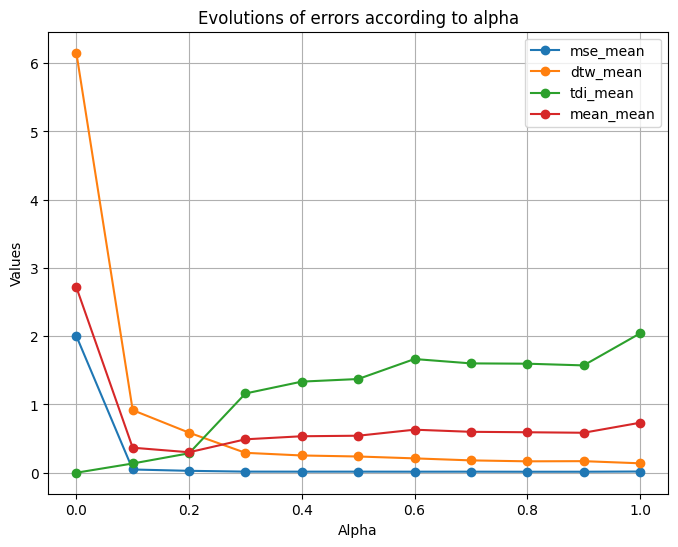

In [5]:
d = {0.01: {0: [(0.13877778649330139, 1.35150266793348, 0.45264), (1.9350389242172241, 6.040631592833701, 0.0), (1.93688063621521, 6.043670789858805, 0.0), (1.939285159111023, 6.0476364208490585, 0.0), (1.9421241521835326, 6.052315519776255, 0.0), (1.9452887535095216, 6.057526846724994, 0.0), (1.9487782716751099, 6.063268233642876, 0.0), (1.9524827003479004, 6.0693573244004195, 0.0), (1.9563366889953613, 6.075685805829902, 0.0), (1.960364866256714, 6.082293383721077, 0.0), (1.9644883394241333, 6.089049963871085, 0.0), (1.9687226295471192, 6.0959804786263945, 0.0), (1.9729846239089965, 6.102948338107766, 0.0), (1.9773289918899537, 6.110042865070689, 0.0), (1.9817020893096924, 6.117175967057134, 0.0), (1.9860931873321532, 6.1243304072544955, 0.0), (1.990506911277771, 6.1315132393346445, 0.0), (1.99490168094635, 6.138656925077707, 0.0), (1.9993431568145752, 6.14586843695931, 0.0), (2.00377414226532, 6.153054349271814, 0.0)], 0.1: [(0.8072125554084778, 3.7546400085738343, 0.051705), (0.1358037382364273, 1.395342366005244, 0.152805), (0.08625832945108414, 1.1060346100703586, 0.12420999999999997), (0.06802932247519493, 1.009814389285194, 0.166055), (0.052227874845266344, 0.935366045358877, 0.12254000000000001), (0.05328486785292626, 0.9615950641374281, 0.10103500000000001), (0.04912533015012741, 0.9328513630505043, 0.164415), (0.048364955186843875, 0.9259276073824534, 0.157235), (0.04723877087235451, 0.9211990986773977, 0.15969000000000003), (0.04612790569663048, 0.9161837615238058, 0.12822), (0.05169709175825119, 0.9729289815685359, 0.10504), (0.04719341993331909, 0.9294648260951602, 0.10883000000000001), (0.04574859812855721, 0.9155406741300613, 0.09275), (0.04733484461903572, 0.9295638962247896, 0.07723), (0.048694228380918504, 0.9411200252880529, 0.07037), (0.043210551142692566, 0.8840236549677847, 0.11471), (0.050074000656604764, 0.9546846307699877, 0.088195), (0.04352565780282021, 0.8841287167961884, 0.11297000000000001), (0.04310641810297966, 0.8790151695878811, 0.10109500000000002), (0.04731647372245788, 0.9171036687621859, 0.13519499999999998)], 0.2: [(0.042140015959739686, 0.8466654768611053, 0.11512999999999998), (0.027805042266845704, 0.6497755543899764, 0.15128999999999998), (0.02748084217309952, 0.634110625597426, 0.17881999999999998), (0.027506082877516748, 0.6231961267947533, 0.23089500000000002), (0.027272019162774087, 0.6137926922192823, 0.23662999999999998), (0.028546489775180817, 0.6247981587097613, 0.25658), (0.02856479175388813, 0.6131384512735263, 0.20532999999999996), (0.02719365991652012, 0.5963204093828651, 0.27095), (0.027199627086520194, 0.5990752850310205, 0.27167), (0.027483848482370378, 0.5937555162725856, 0.30734000000000006), (0.027774565666913987, 0.5996427974526353, 0.30127000000000004), (0.028707784414291383, 0.6165098773904116, 0.28336), (0.02774353064596653, 0.5930658556753619, 0.28229), (0.027339721843600274, 0.5836959614992011, 0.299855), (0.02758222706615925, 0.5865756292157132, 0.3115), (0.027877672016620635, 0.5874460483455796, 0.32121000000000005), (0.027551789209246634, 0.5864854836174095, 0.27378), (0.028420478478074072, 0.5930717830162955, 0.32397), (0.02773258797824383, 0.5882642839634216, 0.30746500000000004), (0.027817467227578163, 0.5866690518274787, 0.2846350000000001)], 0.3: [(0.022117220982909202, 0.43044554300832016, 0.56657), (0.015507414378225804, 0.2881373309092014, 0.9819150000000002), (0.017454589903354644, 0.30791739552163916, 0.8260799999999999), (0.015238485299050808, 0.27811862515588937, 1.0588700000000002), (0.01570819318294525, 0.28934266832461714, 1.04099), (0.015651449933648108, 0.2773672084897859, 1.2209850000000002), (0.015756064280867576, 0.28161401922854423, 1.10417), (0.015746981278061865, 0.27982396029356904, 1.1363), (0.01573505736887455, 0.28029200879726146, 1.1648050000000005), (0.01593422256410122, 0.28171430255292645, 1.21981), (0.016681872121989728, 0.29116614834938515, 1.15035), (0.015477462485432626, 0.27656889362513215, 1.1766700000000003), (0.016165054589509963, 0.29019699503434404, 1.1724799999999997), (0.01723625585436821, 0.27828014873231716, 1.2989149999999996), (0.01637819241732359, 0.2856655186588538, 1.2992949999999994), (0.01743082944303751, 0.2903379039502749, 1.274105), (0.01572142671793699, 0.28973450634349573, 1.17591), (0.01601436361670494, 0.2872031299190544, 1.209495), (0.01603912003338337, 0.29035304469024065, 1.19162), (0.016208162158727647, 0.29149764080703433, 1.1609649999999998)], 0.4: [(0.016245575062930583, 0.2774186107679676, 1.214485), (0.016312241740524768, 0.26417840321265257, 1.3091700000000002), (0.015833807364106178, 0.2615706448016214, 1.2761599999999997), (0.015878209844231606, 0.2642174759164844, 1.2745599999999997), (0.01586983036249876, 0.2648171468083622, 1.2578999999999998), (0.01593677531927824, 0.26548101551203174, 1.2221350000000002), (0.01528726052492857, 0.2508634619630117, 1.32884), (0.015287375822663308, 0.25629783484629093, 1.2753650000000005), (0.015396175533533096, 0.2574408098900204, 1.2698400000000003), (0.015514942444860935, 0.25975098683326003, 1.24119), (0.015553568489849567, 0.26227287390285353, 1.2829950000000003), (0.015684273466467856, 0.2643398588249989, 1.214265), (0.016240476816892623, 0.26789512867617987, 1.2873750000000002), (0.01523182038217783, 0.25023132549703647, 1.28228), (0.015303022786974907, 0.247990753272716, 1.3251250000000003), (0.01569854710251093, 0.25182715702847075, 1.3605250000000004), (0.015222014486789703, 0.24949544780121363, 1.2459549999999997), (0.015565919876098632, 0.24965746170451847, 1.35054), (0.0156689066439867, 0.25165255338542486, 1.3002499999999997), (0.015717120654881, 0.25262750500990644, 1.334755)], 0.5: [(0.015673978812992574, 0.2689667457486705, 1.2343050000000002), (0.014942182786762714, 0.2340278594574506, 1.287475), (0.014890492334961892, 0.23241893027543367, 1.4509400000000003), (0.015178437530994415, 0.22991855545545065, 1.690905), (0.01562057826668024, 0.23223824249152822, 1.5054750000000001), (0.01583945769816637, 0.2316301753735762, 1.6510299999999998), (0.01405098382383585, 0.21753332354244964, 1.3606100000000005), (0.014214271865785121, 0.21956636026675427, 1.3463550000000002), (0.01432174351066351, 0.22156438974524595, 1.30519), (0.014375783503055573, 0.2226234384805597, 1.3401750000000003), (0.015163400769233703, 0.22379979753123322, 1.4068050000000003), (0.01555708386003971, 0.23064212672925266, 1.4459649999999997), (0.01551952064037323, 0.22555119908907395, 1.3671599999999997), (0.015361112356185914, 0.22785294200001793, 1.4264899999999998), (0.015362679772078992, 0.2245160984846417, 1.3858849999999996), (0.016892179474234582, 0.24221274219144334, 1.5114749999999995), (0.01678286138921976, 0.2293865985773757, 1.472585), (0.01551455520093441, 0.23711424745704385, 1.4852349999999999), (0.015694179572165012, 0.23676732681265605, 1.41445), (0.015780874714255332, 0.2376694191324086, 1.372715)], 0.6: [(0.016219346784055233, 0.2658271616114873, 1.1964850000000002), (0.015409711375832557, 0.22291144304034746, 1.382195), (0.014042009599506855, 0.20749821905973048, 1.6238500000000002), (0.015184022672474384, 0.2161252008369976, 1.57854), (0.015296057984232902, 0.21682136544318603, 1.535315), (0.015448160283267499, 0.21784906595321463, 1.5466699999999998), (0.015566697530448436, 0.21842531854788616, 1.519765), (0.015652529895305634, 0.21857320365655392, 1.483955), (0.01577564310282469, 0.22048850620618107, 1.5430300000000003), (0.015677513740956783, 0.21899761786153685, 1.49154), (0.015786825306713582, 0.21951964884583347, 1.4856950000000002), (0.01576483342796564, 0.21184807390164956, 1.5994349999999997), (0.015010465495288372, 0.199711621329342, 1.6225099999999995), (0.015000268071889877, 0.20347144401560197, 1.6516299999999997), (0.015158597379922867, 0.20352647264011595, 1.7088649999999994), (0.015184245631098747, 0.20556784502328976, 1.6499650000000003), (0.015244229324162006, 0.2065523787130666, 1.6721149999999998), (0.01527796983718872, 0.2074669305265237, 1.660175), (0.015248622000217437, 0.20819593301758496, 1.58166), (0.015290158055722713, 0.2103022598884745, 1.66555)], 0.7: [(0.015664584189653396, 0.21316427291776355, 1.7528750000000002), (0.016109992377460004, 0.19962831772149808, 1.62832), (0.015673418901860713, 0.1939845127660269, 1.6991), (0.01550293955951929, 0.18864934783750176, 1.7430400000000001), (0.015051831305027009, 0.18646536373877476, 1.582645), (0.015148750878870488, 0.18690559356478448, 1.6081050000000001), (0.015162013098597526, 0.1863209961172406, 1.5521700000000005), (0.015160351246595382, 0.1865066656635558, 1.54469), (0.015158703550696373, 0.18656679709527255, 1.5415650000000003), (0.015118955262005329, 0.18688890816110246, 1.5694200000000003), (0.015102963894605637, 0.18680692945805896, 1.6458000000000002), (0.015082376822829247, 0.18663223863824646, 1.595715), (0.015053120627999305, 0.18740430251387688, 1.582535), (0.01931776516139507, 0.22293083464624797, 1.7363149999999998), (0.01528856623917818, 0.18279697722171936, 1.7210349999999999), (0.01509199347347021, 0.17610685743192084, 1.5937349999999997), (0.01566730011254549, 0.17974874234037186, 1.5549749999999998), (0.014995467104017734, 0.18116428461148953, 1.5274299999999996), (0.01555159892886877, 0.18326692018931065, 1.55355), (0.015522915497422218, 0.18074656121415478, 1.6017299999999999)], 0.8: [(0.016383537091314793, 0.19525882800085845, 1.470145), (0.01572652943432331, 0.17089210794221898, 1.7158649999999995), (0.01565419714897871, 0.17071174650216484, 1.6362949999999998), (0.015623619593679906, 0.1712572394151337, 1.5984099999999999), (0.015680640190839767, 0.171340380516151, 1.57024), (0.0157111331820488, 0.17208205641339486, 1.5474599999999998), (0.015312830545008182, 0.16909251490537555, 1.742055), (0.015017186850309372, 0.16714547830230392, 1.6776699999999998), (0.015095981024205684, 0.17451152168509124, 1.48547), (0.015081560425460338, 0.16295389739342334, 1.732695), (0.014315477199852466, 0.1652087386648909, 1.620055), (0.014393417537212372, 0.1635517133703099, 1.5235800000000004), (0.0144637119024992, 0.16430707169238842, 1.5496649999999996), (0.01450684405863285, 0.1650028022710511, 1.59984), (0.01445373110473156, 0.16647404926983855, 1.5171599999999996), (0.014441436529159546, 0.16720310206946679, 1.52538), (0.014456263184547425, 0.1664478234665628, 1.53737), (0.0144563814625144, 0.16651415873524694, 1.5527), (0.01447177268564701, 0.16678712690872616, 1.5608200000000003), (0.01447585690766573, 0.16696463871811712, 1.5972500000000003)], 0.9: [(0.014898580498993397, 0.17247711915891756, 1.6554949999999997), (0.014833718910813332, 0.1673104887011345, 1.6662149999999998), (0.014671488106250763, 0.16755921415994385, 1.6829499999999995), (0.014646298252046108, 0.1662030114778791, 1.6420299999999997), (0.014364725910127163, 0.1691676702192335, 1.6328099999999997), (0.01634313091635704, 0.17536538237350616, 1.65694), (0.01586171854287386, 0.15600516827643945, 1.7017249999999997), (0.01728375218808651, 0.15685781731610016, 1.8587199999999995), (0.017265503481030463, 0.1576566178368331, 1.8162299999999991), (0.017211051657795906, 0.15738744201303917, 1.8326099999999996), (0.01712762489914894, 0.1573091754579769, 1.8699349999999995), (0.017176075652241708, 0.15713514065445106, 1.8263749999999994), (0.01714681088924408, 0.15708536323254804, 1.8139200000000002), (0.01718045212328434, 0.1570366893251028, 1.8137899999999998), (0.017165448144078256, 0.15729884682889686, 1.7843450000000005), (0.017149201408028603, 0.15689493449318775, 1.75426), (0.017131748050451277, 0.15686808922226464, 1.7466249999999994), (0.017331554740667342, 0.1725450146302735, 1.733795), (0.015329833328723907, 0.17220200932252877, 1.68839), (0.014728507027029991, 0.1693885075715696, 1.57236)], 1: [(0.01758984513580799, 0.15728298554517756, 1.668795), (0.017127237841486932, 0.14889886284594875, 1.80055), (0.0170088654384017, 0.1486523957031774, 1.781935), (0.016953781992197037, 0.1481935376132335, 1.7210800000000002), (0.01904080994427204, 0.15192571959692977, 1.9168150000000004), (0.01767586749047041, 0.14393284687509872, 1.8591250000000001), (0.018128450959920883, 0.14274611450658542, 2.0956400000000004), (0.01805277820676565, 0.14312606069192868, 2.0801000000000003), (0.018053589574992656, 0.1435066836432811, 2.063065), (0.01805517580360174, 0.14438704712642386, 2.0459), (0.01806132812052965, 0.14432461500972343, 2.0132849999999998), (0.018023811839520933, 0.1445380291603437, 1.9687550000000003), (0.018040637113153936, 0.1446067287826003, 1.98495), (0.018045311234891413, 0.145178501468032, 1.9630000000000003), (0.01803259812295437, 0.14520864675971396, 1.95622), (0.017936121486127377, 0.14853251592051342, 1.823635), (0.018631971813738345, 0.15747517995981744, 1.8034050000000001), (0.017649603076279163, 0.13844724512710727, 1.90595), (0.017803665436804294, 0.13770469944111, 2.002545), (0.017844751104712488, 0.13800439954388827, 2.0406549999999997)]}}
import matplotlib.pyplot as plt
def plot_last_tuples(dictionary):
   
    keys = []
    values_x = []
    values_y = []
    values_z = []
    values_m = []

    for key, value_list in dictionary.items():
        if value_list:
            keys.append(key)
            x, y, z = value_list[-1]  # Dernier tuple
            values_x.append(x)
            values_y.append(y)
            values_z.append(z)
            values_m.append((z+y+x)/3)

    # Tracer les points
    plt.figure(figsize=(8, 6))
    plt.plot(keys, values_x, marker='o', label='mse_mean')
    plt.plot(keys, values_y, marker='o', label='dtw_mean')
    plt.plot(keys, values_z, marker='o', label='tdi_mean')
    plt.plot(keys, values_m, marker='o', label='mean_mean')

    # Ajouter des détails
    plt.xlabel('Alpha')
    plt.ylabel('Values')
    plt.title('Evolutions of errors according to alpha')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_last_tuples(d[0.01])

# Influence de k sur la vitesse

Temps moyen pour k=10: 0.1407 secondes
Temps moyen pour k=20: 0.2397 secondes
Temps moyen pour k=30: 0.2964 secondes
Temps moyen pour k=40: 0.3384 secondes
Temps moyen pour k=50: 0.3914 secondes


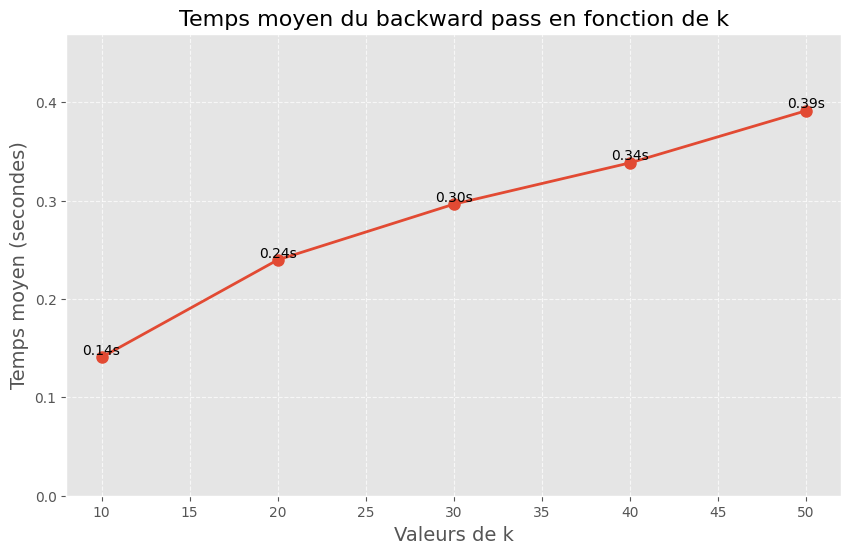

In [40]:
import time

    
def improved_plot(k_list, times_k):
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_list, times_k, marker='o', linestyle='-', linewidth=2, markersize=8)
    
    # Ajouter des annotations pour chaque point
    for k, time in zip(k_list, times_k):
        plt.text(k, time, f'{time:.2f}s', fontsize=10, ha='center', va='bottom')

    # Ajouter des titres et étiquettes
    plt.title('Temps moyen du backward pass en fonction de k', fontsize=16)
    plt.xlabel('Valeurs de k', fontsize=14)
    plt.ylabel('Temps moyen (secondes)', fontsize=14)

    # Ajouter une grille pour mieux visualiser les points
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Afficher les limites pour une meilleure vue
    plt.ylim(0, max(times_k) * 1.2)
    
    # Ajouter un style visuel agréable
    plt.style.use('ggplot')
    
    # Afficher le graphique
    plt.show()



def speed_test(n_iter, net, trainloader, loss_type, learning_rate, gamma=0.001, alpha=0.5):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    times = []
    for _ in range(n_iter):
        data_iter = iter(trainloader)
        inputs, target, _ = next(data_iter)
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        # Backward
        start = time.time()
        loss, _, _ = dilate_loss(target, outputs, alpha, gamma, device)
        loss.backward()  # Ajout du backward ici pour mesurer le temps correctement
        end = time.time()
        times.append(end - start)
                
    return sum(times) / len(times)

def k_speed_test(k_list):
    times_k = []
    for k in k_list:
        gamma = 0.001
        alpha = 0.5

        # Création du dataset avec k comme target size
        batch_size = 100
        N = 500
        N_input = 20
        N_output = k
        sigma = 0.01

        X_train_input, X_train_target, X_test_input, X_test_target, train_bkp, test_bkp = create_synthetic_dataset(
            N, N_input, N_output, sigma
        )
        dataset_train = SyntheticDataset(X_train_input, X_train_target, train_bkp)
        trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)

        # Initialisation du modèle
        encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
        decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, fc_units=16, output_size=1).to(device)
        net_gru_dilate = Net_GRU(encoder, decoder, k, device).to(device)

        # Calcul du temps moyen
        average_time = speed_test(
            10, net_gru_dilate, trainloader, loss_type='dilate', learning_rate=0.001, gamma=gamma, alpha=alpha
        )
        print(f"Temps moyen pour k={k}: {average_time:.4f} secondes")
        times_k.append(average_time)

    # Visualisation
    improved_plot(k_list, times_k)

# Exécutez le test pour les différentes valeurs de k
k_speed_test([10, 20, 30, 40, 50])


# Visualizations

In [ ]:


# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)
        plt.xticks(range(0,40,2))
        plt.legend()
        k = k+1

    plt.show()
